## 0. Loading the libraries

In [2]:
import flax  # neural network modules for jax
import jax
import jax.numpy as jnp
import jraph  # graph neural networks in jax
import matplotlib.pyplot as plt
import numpy as np
import optax  # optimizers for jax
from matscipy.neighbours import neighbour_list  # fast neighbour list implementation

from nequip_jax import NEQUIPLayerFlax  # e3nn implementation of NEQUIP
import e3nn_jax as e3nn

## 1. Creating a graph

In [4]:
def compute_edges(positions, cell, cutoff):
    """Compute edges of the graph from positions and cell."""
    receivers, senders, senders_unit_shifts = neighbour_list(
        quantities="ijS",
        pbc=np.array([True, True, True]),
        cell=cell,
        positions=positions,
        cutoff=cutoff,
    )

    num_edges = senders.shape[0]
    assert senders.shape == (num_edges,)
    assert receivers.shape == (num_edges,)
    assert senders_unit_shifts.shape == (num_edges, 3)
    return senders, receivers, senders_unit_shifts

In [5]:
def create_graph(positions, cell, energy, cutoff):
    """Create a graph from positions, cell, and energy."""
    senders, receivers, senders_unit_shifts = compute_edges(positions, cell, cutoff)

    # In a jraph.GraphsTuple object, nodes, edges, and globals can be any
    # pytree. We will use dicts of arrays.
    # What matters is that the first axis of each array has length equal to
    # the number of nodes, edges, or graphs.
    num_nodes = positions.shape[0]
    num_edges = senders.shape[0]

    graph = jraph.GraphsTuple(
        # positions are per-node features:
        nodes=dict(positions=positions),
        # Unit shifts are per-edge features:
        edges=dict(shifts=senders_unit_shifts),
        # energy and cell are per-graph features:
        globals=dict(energies=np.array([energy]), cells=cell[None, :, :]),
        # The rest of the fields describe the connectivity and size of the graph.
        senders=senders,
        receivers=receivers,
        n_node=np.array([num_nodes]),
        n_edge=np.array([num_edges]),
    )
    return graph

In [6]:
cutoff = 2.0  # in angstroms

In [7]:
mp47 = create_graph(
    positions=np.array(
        [
            [-0.0, 1.44528, 0.26183],
            [1.25165, 0.72264, 2.34632],
            [1.25165, 0.72264, 3.90714],
            [-0.0, 1.44528, 1.82265],
        ]
    ),
    cell=np.array([[2.5033, 0.0, 0.0], [-1.25165, 2.16792, 0.0], [0.0, 0.0, 4.16897]]),
    energy=0.163,  # eV/atom
    cutoff=cutoff,
)
print(f"mp47 has {mp47.n_node} nodes and {mp47.n_edge} edges")

mp48 = create_graph(
    positions=np.array(
        [
            [0.0, 0.0, 1.95077],
            [0.0, 0.0, 5.8523],
            [-0.0, 1.42449, 1.95077],
            [1.23365, 0.71225, 5.8523],
        ]
    ),
    cell=np.array([[2.46729, 0.0, 0.0], [-1.23365, 2.13674, 0.0], [0.0, 0.0, 7.80307]]),
    energy=0.008,  # eV/atom
    cutoff=cutoff,
)
print(f"mp48 has {mp48.n_node} nodes and {mp48.n_edge} edges")

mp66 = create_graph(
    positions=np.array(
        [
            [0.0, 0.0, 1.78037],
            [0.89019, 0.89019, 2.67056],
            [0.0, 1.78037, 0.0],
            [0.89019, 2.67056, 0.89019],
            [1.78037, 0.0, 0.0],
            [2.67056, 0.89019, 0.89019],
            [1.78037, 1.78037, 1.78037],
            [2.67056, 2.67056, 2.67056],
        ]
    ),
    cell=np.array([[3.56075, 0.0, 0.0], [0.0, 3.56075, 0.0], [0.0, 0.0, 3.56075]]),
    energy=0.138,  # eV/atom
    cutoff=cutoff,
)
print(f"mp66 has {mp66.n_node} nodes and {mp66.n_edge} edges")

mp169 = create_graph(
    positions=np.array(
        [
            [-0.66993, 0.0, 3.5025],
            [3.5455, 0.0, 0.00033],
            [1.45739, 1.22828, 3.5025],
            [1.41818, 1.22828, 0.00033],
        ]
    ),
    cell=np.array([[4.25464, 0.0, 0.0], [0.0, 2.45656, 0.0], [-1.37907, 0.0, 3.50283]]),
    energy=0.003,  # eV/atom
    cutoff=cutoff,
)
print(f"mp169 has {mp169.n_node} nodes and {mp169.n_edge} edges")

mp47 has [4] nodes and [16] edges
mp48 has [4] nodes and [12] edges
mp66 has [8] nodes and [32] edges
mp169 has [4] nodes and [12] edges


In [8]:
dataset = jraph.batch([mp47, mp48, mp66, mp169])
print(f"dataset has {dataset.n_node} nodes and {dataset.n_edge} edges")

# Print the shapes of the fields of the dataset.
print(jax.tree_util.tree_map(jnp.shape, dataset))

2024-10-12 17:08:23.342277: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.77). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


dataset has [4 4 8 4] nodes and [16 12 32 12] edges
GraphsTuple(nodes={'positions': (20, 3)}, edges={'shifts': (72, 3)}, receivers=(72,), senders=(72,), globals={'cells': (4, 3, 3), 'energies': (4,)}, n_node=(4,), n_edge=(4,))


## Model

### Get relative positions


In [13]:
def get_relative_vectors(senders, receivers, n_edge, positions, cells, shifts):
    """Compute the relative vectors between the senders and receivers."""
    num_nodes = positions.shape[0]
    num_edges = senders.shape[0]
    num_graphs = n_edge.shape[0]

    assert positions.shape == (num_nodes, 3)
    assert cells.shape == (num_graphs, 3, 3)
    assert senders.shape == (num_edges,)
    assert receivers.shape == (num_edges,)
    assert shifts.shape == (num_edges, 3)

    # We need to repeat the cells for each edge.
    cells = jnp.repeat(cells, n_edge, axis=0, total_repeat_length=num_edges)

    # Compute the two ends of each edge.
    positions_receivers = positions[receivers]
    positions_senders = positions[senders] + jnp.einsum("ei,eij->ej", shifts, cells) # good way of not caring what dot product really is

    vectors = e3nn.IrrepsArray("1o", positions_receivers - positions_senders)
    return vectors

In [42]:
graphs = dataset
num_nodes = graphs.nodes["positions"].shape[0]
senders = graphs.senders
receivers = graphs.receivers
vectors = get_relative_vectors(
        senders,
        receivers,
        graphs.n_edge,
        positions=graphs.nodes["positions"],
        cells=graphs.globals["cells"],
        shifts=graphs.edges["shifts"],
)


n_edge = graphs.n_edge

positions=graphs.nodes["positions"]
cells=graphs.globals["cells"]
shifts=graphs.edges["shifts"]

num_nodes = positions.shape[0]
num_edges = senders.shape[0]
num_graphs = n_edge.shape[0]

cells = jnp.repeat(cells, n_edge, axis=0, total_repeat_length=num_edges)

# Compute the two ends of each edge.
positions_receivers = positions[receivers]
positions_senders = positions[senders] + jnp.einsum("ei,eij->ej", shifts, cells) # good way of not caring what dot product really is


print((positions_receivers - positions_senders)[:5])
print("Irrep 1x1o", vectors[:5]) # inside vectors are positions

[[ 1.25165     0.72264     0.52366006]
 [-1.25165     0.72264     0.52366006]
 [-0.         -1.4452802   0.52366006]
 [-0.          0.         -1.56082   ]
 [ 0.          1.4452801   0.52366996]]
Irrep 1x1o 1x1o
[[ 1.25165     0.72264     0.52366006]
 [-1.25165     0.72264     0.52366006]
 [-0.         -1.4452802   0.52366006]
 [-0.          0.         -1.56082   ]
 [ 0.          1.4452801   0.52366996]]


In [43]:
from typing import Callable, Optional, Union

import e3nn_jax as e3nn
import flax
import haiku as hk
import jax
import jax.numpy as jnp

import e3nn_jax as e3nn


def default_radial_basis(r, n: int):
    """Default radial basis function."""
    return e3nn.bessel(r, n) * e3nn.poly_envelope(5, 2)(r)[:, None]


def simple_smooth_radial_basis(r, n: int):
    return e3nn.soft_one_hot_linspace(
        r,
        start=0.0,
        end=1.0,
        number=n,
        basis="smooth_finite",
        start_zero=False,
        end_zero=True,
    )

class NEQUIPLayerFlax(flax.linen.Module):
    avg_num_neighbors: float
    num_species: int = 1
    max_ell: int = 3
    output_irreps: e3nn.Irreps = 64 * e3nn.Irreps("0e + 1o + 2e")
    even_activation: Callable[[jnp.ndarray], jnp.ndarray] = jax.nn.silu
    odd_activation: Callable[[jnp.ndarray], jnp.ndarray] = jax.nn.tanh
    gate_activation: Callable[[jnp.ndarray], jnp.ndarray] = jax.nn.silu
    mlp_activation: Callable[[jnp.ndarray], jnp.ndarray] = jax.nn.silu
    mlp_n_hidden: int = 64
    mlp_n_layers: int = 2
    radial_basis: Callable[[jnp.ndarray, int], jnp.ndarray] = default_radial_basis
    n_radial_basis: int = 8

    @flax.linen.compact
    def __call__(
        self,
        vectors: e3nn.IrrepsArray,
        node_feats: e3nn.IrrepsArray,
        node_specie: jnp.ndarray,
        senders: jnp.ndarray,
        receivers: jnp.ndarray,
    ):
        return _impl(
            e3nn.flax.Linear,
            e3nn.flax.MultiLayerPerceptron,
            self,
            vectors,
            node_feats,
            node_specie,
            senders,
            receivers,
        )


def _impl(
    Linear: Callable,
    MultiLayerPerceptron: Callable,
    self: Union[NEQUIPLayerFlax],
    vectors: e3nn.IrrepsArray,  # [n_edges, 3]
    node_feats: e3nn.IrrepsArray,  # [n_nodes, irreps]
    node_specie: jnp.ndarray,  # [n_nodes] int between 0 and num_species-1
    senders: jnp.ndarray,  # [n_edges]
    receivers: jnp.ndarray,  # [n_edges]
):
    node_feats = e3nn.as_irreps_array(node_feats)

    num_nodes = node_feats.shape[0]
    num_edges = vectors.shape[0]
    assert vectors.shape == (num_edges, 3)
    assert node_feats.shape == (num_nodes, node_feats.irreps.dim)
    assert node_specie.shape == (num_nodes,)
    assert senders.shape == (num_edges,)
    assert receivers.shape == (num_edges,)

    # we regroup the target irreps to make sure that gate activation
    # has the same irreps as the target
    output_irreps = e3nn.Irreps(self.output_irreps).regroup()

    messages = Linear(node_feats.irreps, name="linear_up")(node_feats)[senders] # linear is just linear mixing of the channels

    # Angular part
    messages = e3nn.concatenate(
        [
            messages.filter(output_irreps + "0e"),
            e3nn.tensor_product(
                messages,
                e3nn.spherical_harmonics(
                    [l for l in range(1, self.max_ell + 1)],
                    vectors,
                    normalize=True,
                    normalization="component",
                ),
                filter_ir_out=output_irreps + "0e",
            ),
        ]
    ).regroup()
    assert messages.shape == (num_edges, messages.irreps.dim)

    # Radial part
    with jax.ensure_compile_time_eval():
        assert abs(self.mlp_activation(0.0)) < 1e-6
    lengths = e3nn.norm(vectors).array
    mix = MultiLayerPerceptron(
        self.mlp_n_layers * (self.mlp_n_hidden,) + (messages.irreps.num_irreps,),
        self.mlp_activation,
        output_activation=False,
    )(self.radial_basis(lengths[:, 0], self.n_radial_basis))

    # Discard 0 length edges that come from graph padding
    mix = jnp.where(lengths == 0.0, 0.0, mix)
    assert mix.shape == (num_edges, messages.irreps.num_irreps)

    # Product of radial and angular part
    messages = messages * mix
    assert messages.shape == (num_edges, messages.irreps.dim)

    # Skip connection
    irreps = output_irreps.filter(keep=messages.irreps)
    num_nonscalar = irreps.filter(drop="0e + 0o").num_irreps
    irreps = irreps + e3nn.Irreps(f"{num_nonscalar}x0e").simplify()

    skip = Linear(
        irreps,
        num_indexed_weights=self.num_species,
        name="skip_tp",
        force_irreps_out=True,
    )(node_specie, node_feats)

    # Message passing
    node_feats = e3nn.scatter_sum(messages, dst=receivers, output_size=num_nodes)
    node_feats = node_feats / jnp.sqrt(self.avg_num_neighbors)

    node_feats = Linear(irreps, name="linear_down")(node_feats)

    node_feats = node_feats + skip
    assert node_feats.shape == (num_nodes, node_feats.irreps.dim)

    node_feats = e3nn.gate(
        node_feats,
        even_act=self.even_activation,
        odd_act=self.odd_activation,
        even_gate_act=self.gate_activation,
    )

    return node_feats

In [44]:
class Model(flax.linen.Module):
    @flax.linen.compact
    def __call__(self, graphs):
        num_nodes = graphs.nodes["positions"].shape[0]
        senders = graphs.senders
        receivers = graphs.receivers

        vectors = get_relative_vectors(
            senders,
            receivers,
            graphs.n_edge,
            positions=graphs.nodes["positions"],
            cells=graphs.globals["cells"],
            shifts=graphs.edges["shifts"],
        )

        # We divide the relative vectors by the cutoff
        # because NEQUIPLayerFlax assumes a cutoff of 1.0
        vectors = vectors / cutoff

        # Embedding: since we have a single atom type, we don't need embedding
        # The node features are just ones and the species indices are all zeros
        features = e3nn.IrrepsArray("0e", jnp.ones((num_nodes, 1)))
        species = jnp.zeros((num_nodes,), dtype=jnp.int32)

        # Apply 3 Nequip layers with different internal representations
        for irreps in [
            "32x0e + 8x1o + 8x2e",
            "32x0e + 8x1o + 8x2e",
            "32x0e",
        ]:
            layer = NEQUIPLayerFlax(
                avg_num_neighbors=20.0,  # average number of neighbors to normalize by
                output_irreps=irreps,
            )
            features = layer(vectors, features, species, senders, receivers)

        # Self-Interaction layers
        features = e3nn.flax.Linear("16x0e")(features)
        features = e3nn.flax.Linear("0e")(features)

        # Global Pooling
        # Average the features (energy prediction) over the nodes of each graph
        return e3nn.scatter_sum(features, nel=graphs.n_node) / graphs.n_node[:, None]

In [45]:
def loss_fn(preds, targets):
    assert preds.shape == targets.shape
    return jnp.mean(jnp.square(preds - targets))

In [46]:
random_key = jax.random.PRNGKey(0)  # change it to get different initializations

# Initialize the model
model = Model()
params = jax.jit(model.init)(random_key, dataset)

# Initialize the optimizer
opt = optax.adam(1e-3)
opt_state = opt.init(params)

In [47]:
@jax.jit
def train_step(opt_state, params, dataset):
    """Perform a single training step."""
    num_graphs = dataset.n_node.shape[0]

    # Compute the loss as a function of the parameters
    def fun(w):
        preds = model.apply(w, dataset).array.squeeze(1)
        targets = dataset.globals["energies"]

        assert preds.shape == (num_graphs,)
        assert targets.shape == (num_graphs,)
        return loss_fn(preds, targets)

    # And take its gradient
    loss, grad = jax.value_and_grad(fun)(params)

    # Update the parameters and the optimizer state
    updates, opt_state = opt.update(grad, opt_state)
    params = optax.apply_updates(params, updates)

    return opt_state, params, loss

In [48]:
losses = []
for _ in range(1000):
    opt_state, params, loss = train_step(opt_state, params, dataset)
    losses.append(loss)

Text(0, 0.5, 'Loss')

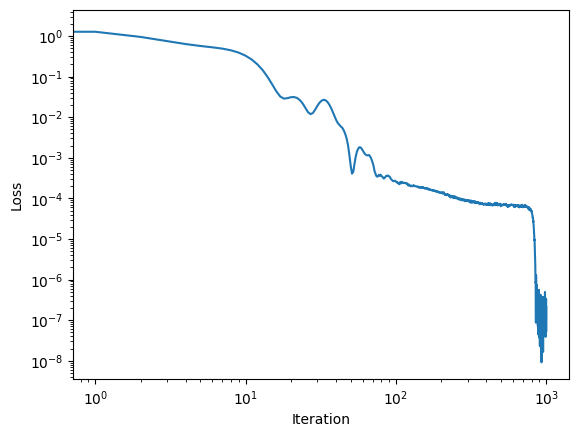

In [49]:
plt.plot(losses)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")